# Tree based methods

In [1]:
# imports
import pandas as pd
import numpy as np
from utils import import_and_transform
from utils import get_churned_users
from utils import aggregate, aggregate_features_improved, aggregate_features_improved2
from utils import evaluate_model

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier



## Import data and apply transformations

### Train data

In [2]:
df_train = import_and_transform("Data/train.parquet")

In [3]:
user_data = import_and_transform(df_train)

In [4]:
user_data.head(1)

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,...,itemInSession,userAgent,method,length,song,artist,time,registration,session_length,song_played
0,200,NaN,Shlok,NaN,Johnson,1749042,2018-10-01 00:00:01,Logged In,NextSong,22683,...,278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21,11405.0,1


### Test data

In [5]:
df_test = import_and_transform("Data/test.parquet")

In [6]:
test_data = import_and_transform(df_test)

In [7]:
test_data.head(1)


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,...,itemInSession,userAgent,method,length,song,artist,time,registration,session_length,song_played
7,200,NaN,Jonathan,NaN,Martin,1465194,2018-10-01 00:00:06,Logged In,NextSong,22483,...,29,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,250.8273,Mockingbird,Eminem,2018-10-01 00:00:06,2018-09-27 17:29:36,46790.0,1


## Aggregate data

In [8]:
# Createing observation dates every 5 days
# Create multiple training samples with sliding window
training_dates = pd.date_range("2018-10-15", "2018-11-05", freq="5D")

X_train_list = []
y_train_list = []

# For each observ date, we create a separate training sample:
for obs_date in training_dates:
    # Filtering data up to the observation date
    df_obs = df_train[df_train["ts"] <= obs_date]
    features = aggregate_features_improved(df_obs, obs_date)   # Better aggregate function.
    # features = aggregate_features_improved2(df_obs, obs_date)  # Better function, but takes ages to run
    
    # Creating a 10 day window after the obervation date
    # And we identify who churned in that period
    window_end = obs_date + pd.Timedelta(days=10)
    churned_users = get_churned_users(df_train, obs_date, window_end)

    # 1 if they churned in the next 10 days, 0 otherwise
    labels = pd.Series(
        features.index.isin(churned_users).astype(int),
        index=features.index,
        name="churned",
    )

    X_train_list.append(features)
    y_train_list.append(labels)

    print(
        f"Date of the observation: {obs_date.date()}, with {len(features)} users, and a {labels.mean():.2%} churn rate"
    )

# We combine all observation windows:
X_train_combined = pd.concat(X_train_list)
y_train_combined = pd.concat(y_train_list)

# Drop non-numeric columns
feature_cols = X_train_combined.select_dtypes(include=[np.number]).columns
feature_cols = [
    c
    for c in feature_cols
    if c not in ["registration", "ts_min", "ts_max", "total_length"]
]

X_train_final = X_train_combined[feature_cols]

Date of the observation: 2018-10-15, with 16271 users, and a 5.08% churn rate
Date of the observation: 2018-10-20, with 17347 users, and a 4.48% churn rate
Date of the observation: 2018-10-25, with 17888 users, and a 4.49% churn rate
Date of the observation: 2018-10-30, with 18271 users, and a 4.46% churn rate
Date of the observation: 2018-11-04, with 18592 users, and a 3.78% churn rate


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_train_final, y_train_combined, 
                                                    test_size=0.20, random_state=42)

In [10]:
test_features = aggregate_features_improved(df_test, "2018-11-20")
test_submission = test_features[feature_cols]

In [11]:
X_train_final.head(1)

,gender,level_first,level_current,num_sessions,avg_session_length,num_songs_played,unique_artists,unique_songs,avg_song_length,days_active,...,downgrade_attempts,upgrade_attempts,total_page_views,has_social_activity,positive_actions,satisfaction_ratio,engagement_rate,problem_signals,ads_per_song,actions_per_session
userId,,,,,,,,,,,,,,,,,,,,,
1000025,1,0,1,11,56774.847498,1030,795,935,249.797113,12,...,14.0,2.0,1259,1,121.0,0.864198,0.131911,0.0,0.00388,104.916667


## Testing out different models

### Decision Tree Classifier

In [12]:
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# 6. Evaluate
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

evaluate_model(clf, test_submission, file_out="submission-dt.csv")

Accuracy: 0.7430689147900872

Confusion Matrix:
 [[12661  4216]
 [  325   472]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.75      0.85     16877
           1       0.10      0.59      0.17       797

    accuracy                           0.74     17674
   macro avg       0.54      0.67      0.51     17674
weighted avg       0.94      0.74      0.82     17674

Base predicted churn: 51.00%
Submission saved to submission-dt.csv


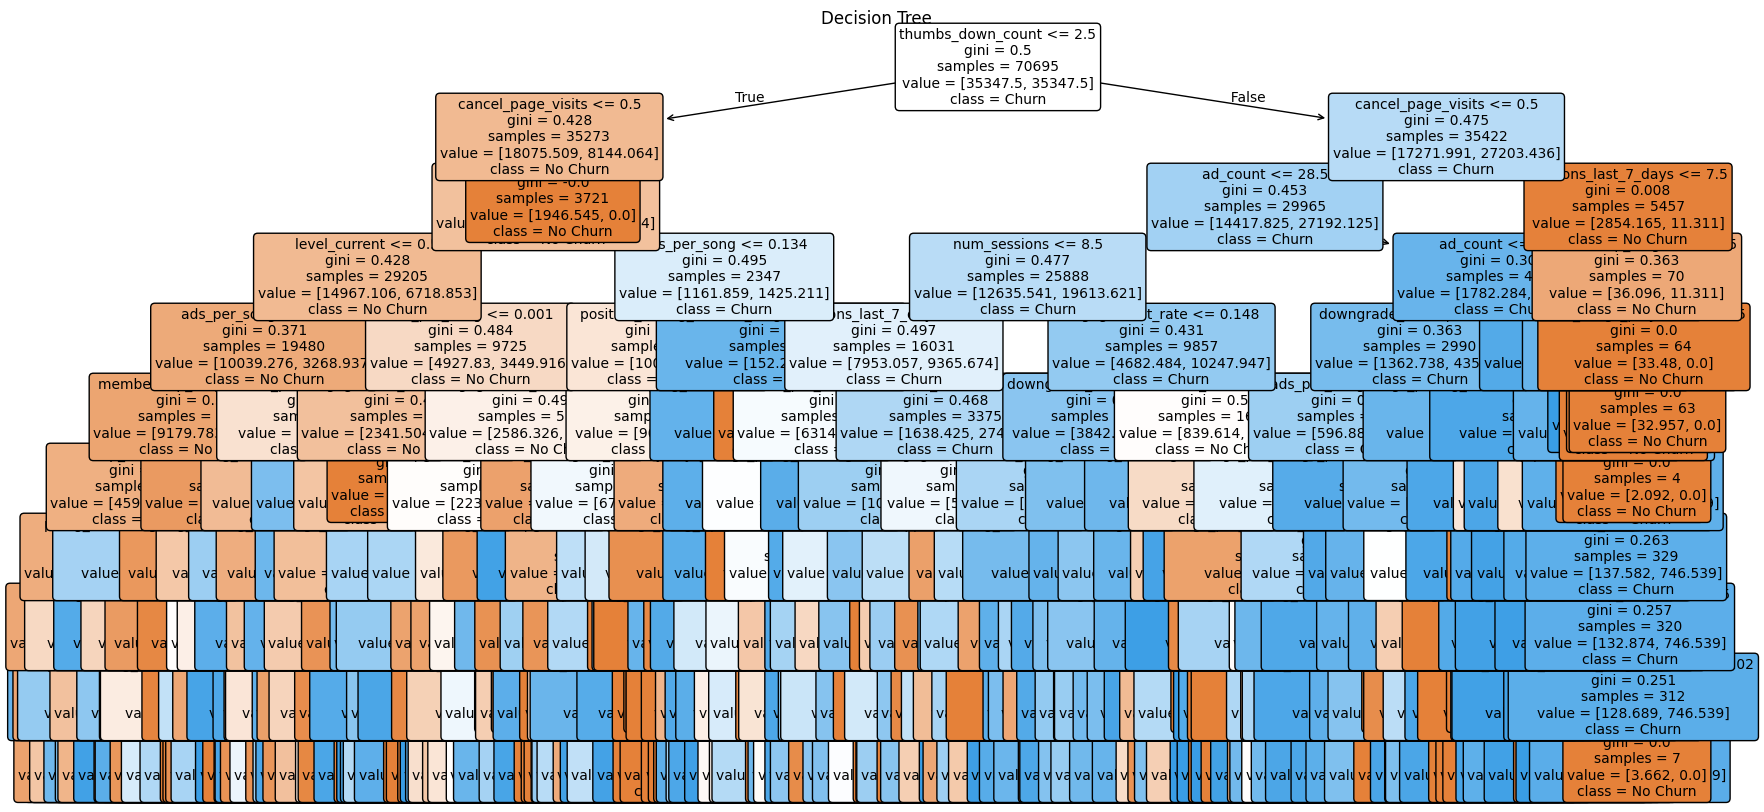

In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=X_train.columns,
    class_names=["No Churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree")
plt.show()

### XGBoost

In [14]:
import xgboost as xgb
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_ratio = neg / pos

clf = xgb.XGBClassifier(
    scale_pos_weight=scale_ratio,  # handles imbalance
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

evaluate_model(clf, test_submission, file_out='submission-xgb.csv')

C:\Users\Martin\Documents\X HEC\env\lib\site-packages\xgboost\training.py:199: UserWarning: [17:17:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[12537  4340]
 [  252   545]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.74      0.85     16877
           1       0.11      0.68      0.19       797

    accuracy                           0.74     17674
   macro avg       0.55      0.71      0.52     17674
weighted avg       0.94      0.74      0.82     17674

F1 Score: 0.19183386131643787
Base predicted churn: 49.04%
Submission saved to submission-xgb.csv


### RandomForest

In [15]:
clf = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 6. Evaluate
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7967636075591265

Confusion Matrix:
 [[13647  3230]
 [  362   435]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.88     16877
           1       0.12      0.55      0.19       797

    accuracy                           0.80     17674
   macro avg       0.55      0.68      0.54     17674
weighted avg       0.94      0.80      0.85     17674



In [16]:
evaluate_model(model=clf, test_set=test_submission, p=0.47, file_out='submission-rf-047.csv')

Base predicted churn: 43.87%
Predicted churn at 0.47 threshold: 48.31%
Submission saved to submission-rf-047.csv


### CatBoost

In [17]:
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scale_pos_weight = (y_train_combined == 0).sum() / (y_train_combined == 1).sum()

cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=50,
    scale_pos_weight=scale_pos_weight
)
cat_model.fit(X_train, y_train)

# Evaluate on original test set
y_pred = cat_model.predict(X_test)
y_proba = cat_model.predict_proba(X_test)[:, 1]

print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



0:	learn: 0.6883023	total: 168ms	remaining: 1m 24s
50:	learn: 0.7157629	total: 847ms	remaining: 7.46s
100:	learn: 0.7281882	total: 1.5s	remaining: 5.92s
150:	learn: 0.7431640	total: 2.13s	remaining: 4.91s
200:	learn: 0.7544502	total: 2.83s	remaining: 4.21s
250:	learn: 0.7685800	total: 3.5s	remaining: 3.47s
300:	learn: 0.7852477	total: 4.16s	remaining: 2.75s
350:	learn: 0.8061215	total: 4.78s	remaining: 2.03s
400:	learn: 0.8219242	total: 5.37s	remaining: 1.32s
450:	learn: 0.8371074	total: 5.97s	remaining: 648ms
499:	learn: 0.8472007	total: 6.56s	remaining: 0us
F1 Score: 0.2070767993566546
ROC-AUC: 0.7986457332553514

Confusion Matrix:
 [[13215  3662]
 [  282   515]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87     16877
           1       0.12      0.65      0.21       797

    accuracy                           0.78     17674
   macro avg       0.55      0.71      0.54     17674
weighted avg       0.94      

In [18]:
evaluate_model(model=cat_model, test_set=test_submission, p=0.45, file_out='submission-catb.csv')


Base predicted churn: 43.22%
Predicted churn at 0.45 threshold: 50.62%
Submission saved to submission-catb.csv


## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
import numpy as np

# Calculate scale_pos_weight
scale_pos_weight = (y_train_combined == 0).sum() / (y_train_combined == 1).sum()

# Base CatBoost model
base_cat = CatBoostClassifier(
    random_seed=42,
    verbose=0,  # Suppress output during grid search
    scale_pos_weight=scale_pos_weight
)

# Parameter grid
param_grid = {
    'iterations': [200, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128],
    'subsample': [0.7, 0.8, 0.9]
}

# Stratified K-Fold for imbalanced data
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search
print("Starting GridSearchCV...")
print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")
print("This may take a while...\n")

grid_search = GridSearchCV(
    estimator=base_cat,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',  # or 'roc_auc' if you prefer
    n_jobs=-1,  # Use all cores
    verbose=2
)

grid_search.fit(X_train_final, y_train_combined)

# Results
print("\n" + "="*50)
print("Best parameters:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
print("\n" + "="*50)
print("Training final model with best parameters...")
best_cat_model = CatBoostClassifier(
    **grid_search.best_params_,
    random_seed=42,
    verbose=50,
    scale_pos_weight=scale_pos_weight
)

best_cat_model.fit(X_train_final, y_train_combined)

# Predictions
cat_predictions = best_cat_model.predict(X_test)
cat_proba = best_cat_model.predict_proba(X_test)[:, 1]

print(f"\nPredicted churn rate: {cat_predictions.mean():.2%}")

# Save submission
submission = pd.DataFrame({
    'userId': test_features.index,
    'prediction': cat_predictions
})
submission.to_csv('submission_catboost_tuned.csv', index=False)
print("Submission saved: submission_catboost_tuned.csv")

# Save best parameters for future reference
import json
with open('best_catboost_params.json', 'w') as f:
    json.dump(grid_search.best_params_, f, indent=2)
print("Best parameters saved: best_catboost_params.json")